In [2]:
# %%
import torch
from torch import nn
import numpy as np

from pit.dynamics.dynamic_bicycle import DynamicBicycle
from pit.integration import Euler, RK4

import matplotlib.pyplot as plt
import json

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(DEVICE)

# input parameters
map_name = 'shoemaker' # 'SaoPaulo'  # Nuerburgring,  SaoPaulo
lap_number = 4 # 2  # 1 - faster, 2 - slower
friction = '0-7' # '1-1'  # '1-1' - mu_x = 1.1, '0-7' - mu_x = 0.7

# visualization
with open('dataset_%s_%s_lap%s.json' % (friction, map_name, lap_number), 'r') as f:
    data = json.load(f)

cpu


/home/xlab/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# %%
timestep = 0.01
assert(data['time'][1] - data['time'][0] - timestep < 0.001)
x = torch.tensor(data['x'])
y = torch.tensor(data['y'])
yaw = torch.tensor(data['yaw'])
vx = torch.tensor(data['vx'])
vy = torch.tensor(data['vy'])
yaw_rate = torch.tensor(data['yaw_rate'])
steer_angle = torch.tensor(data['steer_angle'])
drive_force = torch.tensor(data['drive_force'])
steer_speed = torch.tensor(data['steer_speed'])

In [4]:
# %%
initial_state = torch.tensor([x[0],y[0],yaw[0],vx[0],vy[0],yaw_rate[0],steer_angle[0]]).to(DEVICE)
control_inputs = torch.vstack([drive_force, steer_speed]).T
control_inputs = control_inputs.contiguous().to(DEVICE)
output_states = torch.vstack([x, y, yaw, vx, vy, yaw_rate, steer_angle]).T
## why this?
# target_states = output_states[1:]
target_states = output_states
target_states = target_states.contiguous().to(DEVICE)

print(f"Inputs size: {control_inputs.shape} | States size: {target_states.shape} | Output size: {output_states.shape}")

Inputs size: torch.Size([67395, 2]) | States size: torch.Size([67395, 7]) | Output size: torch.Size([67395, 7])


In [5]:
# %%
STEP_SIZE=10
TICKS_IN_STEP=50
state_dims = initial_state.shape[0]
input_dims = control_inputs.shape[-1]
total_steps = (control_inputs.shape[0]-TICKS_IN_STEP-1)//STEP_SIZE

batched_initial_states = torch.zeros((total_steps, state_dims), device=DEVICE)
batched_control_inputs = torch.zeros((total_steps, TICKS_IN_STEP, input_dims), device=DEVICE)
batched_target_states = torch.zeros((total_steps, TICKS_IN_STEP, state_dims), device=DEVICE)

for step in range(total_steps):
    batched_initial_states[step] = output_states[step*STEP_SIZE]
    batched_control_inputs[step] = control_inputs[step*STEP_SIZE:(step*STEP_SIZE)+TICKS_IN_STEP]
    batched_target_states[step] = output_states[(step*STEP_SIZE)+1:(step*STEP_SIZE)+TICKS_IN_STEP+1]

print(f"Batched Inputs size: {batched_control_inputs.shape} | Batched States size: {batched_target_states.shape}")

Batched Inputs size: torch.Size([6734, 50, 2]) | Batched States size: torch.Size([6734, 50, 7])


In [6]:
# %%
dataset = torch.utils.data.TensorDataset(batched_initial_states, batched_control_inputs, batched_target_states)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)

In [7]:
# %%
params = {
    # axes distances
    'lf': 0.88392,  # distance from spring mass center of gravity to front axle [m]  LENA
    'lr': 1.50876,  # distance from spring mass center of gravity to rear axle [m]  LENB

    # moments of inertia of sprung mass
    # masses
    'Iz': 1538.853371,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
    'mass': 1225.887,  # vehicle mass [kg]  MASS

    # Pacejka tire force parameters
    'Df': 3709.08227,  # [rad/m]  DF
    'Cf': 1.3507,
    'Bf': 16.2216,
    'Dr': 3709.08227,  # [rad/m]  DR
    'Cr': 1.3507,
    'Br': 16.2216,
    'Cm': 0.3777,
    'Cr0': 2.1469,
    'Cr2': 0.0,
}
params_cinnamon = {
    # axes distances
    'lf': 0.2725,  # distance from spring mass center of gravity to front axle [m]  LENA
    'lr': 0.2585,  # distance from spring mass center of gravity to rear axle [m]  LENB

    # moments of inertia of sprung mass
    # masses
    'Iz': 0.6433215993,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
    'mass': 15.32,  # vehicle mass [kg]  MASS

    # Pacejka tire force parameters
    'Df': 3709.08227,  # [rad/m]  DF
    'Cf': 100000000.3507,
    'Bf': 16.2216,
    'Dr': 3709.08227,  # [rad/m]  DR
    'Cr': 1.3507,
    'Br': 16.2216,
    'Cm': 0.3777,
    'Cr0': 2.1469,
    'Cr2': 0.0,
}
# params.update({
#     "lf" : 0.8839200139045715,
# 	"lr" : 1.5087599754333496,
# 	"Iz" : 1538.8533935546875,
# 	"mass" : 1225.8848876953125,
# 	"Df" : 3709.082275390625,
# 	"Cf" : 3.462254762649536,
# 	"Bf" : 16.504972457885742,
# 	"Dr" : 3709.082275390625,
# 	"Cr" : 2.0830910205841064,
# 	"Br" : 16.302648544311523,
# 	"Cm" : 0.9561037421226501,
# 	"Cr0" : 2.1423134803771973,
# 	"Cr2" : -0.010570406913757324,
# })
dynamics = DynamicBicycle(**params_cinnamon)
#dynamics = torch.load("fitted_model.pt")
# <---- FIX PHYSICAL PARAMS     ---->
dynamics.lf.requires_grad = False
dynamics.lr.requires_grad = False
dynamics.mass.requires_grad = True
dynamics.Iz.requires_grad = True
dynamics.Df.requires_grad = True
dynamics.Cf.requires_grad = True
dynamics.Bf.requires_grad = True
dynamics.Dr.requires_grad = True
dynamics.Cr.requires_grad = True
dynamics.Br.requires_grad = True
dynamics.Cm.requires_grad = True
dynamics.Cr0.requires_grad = True
dynamics.Cr2.requires_grad = True
# <----                         ---->
euler_integrator = Euler(dynamics, timestep=timestep)
euler_integrator.to(DEVICE)
rk4_integrator = RK4(dynamics=dynamics, timestep=timestep)
rk4_integrator.to(DEVICE)


RK4(
  (dynamics): DynamicBicycle()
)

In [8]:
with torch.no_grad():
    euler_output_states = euler_integrator(initial_state, control_inputs)
    if euler_output_states.isnan().any():
        print("NaN detected in Euler")


NaNs detected in diff (step 105)
NaNs detected in state (step 105)
NaN encountered in states or control_inputs.
NaNs detected in diff (step 106)
NaNs detected in state (step 106)
NaN encountered in states or control_inputs.
NaNs detected in diff (step 107)
NaNs detected in state (step 107)
NaN encountered in states or control_inputs.
NaNs detected in diff (step 108)
NaNs detected in state (step 108)
NaN encountered in states or control_inputs.
NaNs detected in diff (step 109)
NaNs detected in state (step 109)
NaN encountered in states or control_inputs.
NaNs detected in diff (step 110)
NaNs detected in state (step 110)
NaN encountered in states or control_inputs.
NaNs detected in diff (step 111)
NaNs detected in state (step 111)
NaN encountered in states or control_inputs.
NaNs detected in diff (step 112)
NaNs detected in state (step 112)
NaN encountered in states or control_inputs.
NaNs detected in diff (step 113)
NaNs detected in state (step 113)
NaN encountered in states or control_

KeyboardInterrupt: 

In [ ]:
print(f"target_states shape: {target_states.shape}")
print(f"prediction_states shape: {euler_output_states.shape}")

target_states shape: torch.Size([67395, 7])
prediction_states shape: torch.Size([67395, 7])


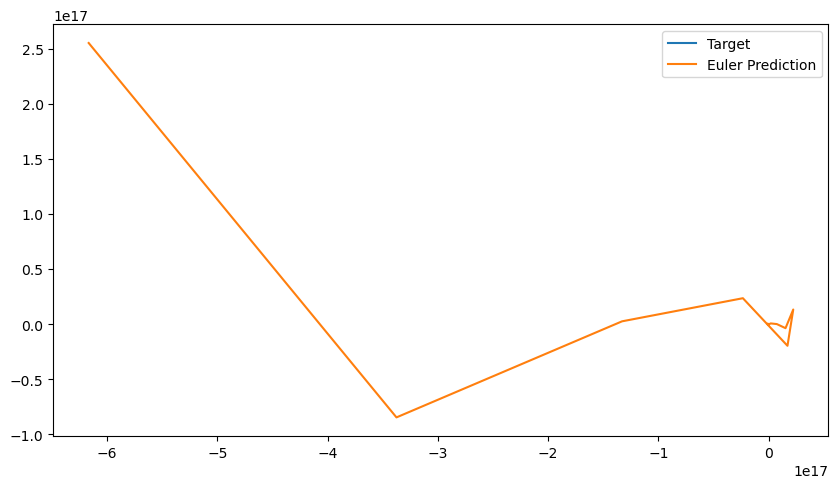

In [ ]:
# %%
fig, ax = plt.subplots(1, 1, figsize=(10,10))
LEN=20000
ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
# if torch.isnan(target_states).any():
#     print("nan")


ax.plot(euler_output_states[:LEN, 0].detach().cpu().numpy(), euler_output_states[:LEN, 1].detach().cpu().numpy(), label="Euler Prediction")
#ax.plot(rk4_output_states[:LEN, 0].detach().cpu().numpy(), rk4_output_states[:LEN, 1].detach().cpu().numpy(), label="RK4 Prediction")
ax.set_aspect(1.0)
ax.legend()

In [ ]:
from tqdm.auto import tqdm
EPOCHS = 100
integrator = euler_integrator
optimizer = torch.optim.SGD(integrator.parameters(), lr=.01, momentum=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.9)

with torch.no_grad():
        if torch.isnan(initial_state).any() or torch.isnan(control_inputs).any():
            print("initial / control NAN detected")
        output_states = integrator(initial_state, control_inputs)
        # if torch.isnan(output_states).any():
            # print("NAN detected")
        val_loss = torch.nn.functional.l1_loss(output_states, target_states)
print(f"Initialized | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

Initialized | Validation Loss: nan | LR: 0.01


In [ ]:
# %%


losses = list()
lrs = list()

for i in tqdm(range(EPOCHS)):
    for initial, inputs, targets in dataloader:
        optimizer.zero_grad()
        output_states = integrator(initial, inputs)
        if torch.isnan(output_states).any():
            print("NAN detected")
            break
        loss = torch.nn.functional.l1_loss(output_states, targets)
        torch.nn.utils.clip_grad_norm_(integrator.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
    #for name, param in integrator.named_parameters():
    #    if param.requires_grad:
    #        print(name, param.data, param.grad)
    if i%20 == 0 and False:
        with torch.no_grad():
            output_states = integrator(initial_state, control_inputs)
            val_loss = torch.nn.functional.l1_loss(output_states, target_states)
        fig, ax = plt.subplots(1, 1, figsize=(10,10))
        LEN=20000
        ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
        ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
        ax.set_aspect(1.0)
        ax.legend()
        plt.show()
        print(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    with torch.no_grad():
        output_states = integrator(batched_initial_states,batched_control_inputs)
        val_loss = torch.nn.functional.l1_loss(output_states, batched_target_states)
        losses.append(val_loss.item())
    print(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step(val_loss)


  1%|          | 1/100 [00:00<00:27,  3.55it/s]

NAN detected
Epoch: 0 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.01
NAN detected


  3%|▎         | 3/100 [00:00<00:15,  6.15it/s]

Epoch: 1 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.01
NAN detected
Epoch: 2 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.01
NAN detected


  5%|▌         | 5/100 [00:00<00:13,  7.22it/s]

Epoch: 3 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.01
NAN detected
Epoch: 4 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.01
NAN detected


  7%|▋         | 7/100 [00:01<00:12,  7.54it/s]

Epoch: 5 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.01
NAN detected
Epoch: 6 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.01
NAN detected


  9%|▉         | 9/100 [00:01<00:11,  7.74it/s]

Epoch: 7 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.01
NAN detected
Epoch: 8 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.01
NAN detected


 11%|█         | 11/100 [00:01<00:11,  7.75it/s]

Epoch: 9 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.01
NAN detected
Epoch: 10 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.01
NAN detected


 13%|█▎        | 13/100 [00:01<00:10,  7.97it/s]

Epoch: 11 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.009000000000000001
NAN detected
Epoch: 12 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.009000000000000001
NAN detected


 15%|█▌        | 15/100 [00:02<00:10,  7.98it/s]

Epoch: 13 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.009000000000000001
NAN detected
Epoch: 14 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.009000000000000001
NAN detected


 17%|█▋        | 17/100 [00:02<00:10,  8.08it/s]

Epoch: 15 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.009000000000000001
NAN detected
Epoch: 16 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.009000000000000001
NAN detected


 19%|█▉        | 19/100 [00:02<00:09,  8.22it/s]

Epoch: 17 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.009000000000000001
NAN detected
Epoch: 18 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.009000000000000001
NAN detected


 21%|██        | 21/100 [00:02<00:09,  8.26it/s]

Epoch: 19 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.009000000000000001
NAN detected
Epoch: 20 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.009000000000000001
NAN detected


 23%|██▎       | 23/100 [00:03<00:09,  8.20it/s]

Epoch: 21 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.009000000000000001
NAN detected
Epoch: 22 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.008100000000000001
NAN detected


 25%|██▌       | 25/100 [00:03<00:09,  7.93it/s]

Epoch: 23 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.008100000000000001
NAN detected
Epoch: 24 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.008100000000000001
NAN detected


 27%|██▋       | 27/100 [00:03<00:09,  8.02it/s]

Epoch: 25 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.008100000000000001
NAN detected
Epoch: 26 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.008100000000000001
NAN detected


 29%|██▉       | 29/100 [00:03<00:08,  8.21it/s]

Epoch: 27 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.008100000000000001
NAN detected
Epoch: 28 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.008100000000000001
NAN detected


 31%|███       | 31/100 [00:03<00:08,  8.41it/s]

Epoch: 29 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.008100000000000001
NAN detected
Epoch: 30 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.008100000000000001
NAN detected


 33%|███▎      | 33/100 [00:04<00:08,  8.28it/s]

Epoch: 31 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.008100000000000001
NAN detected
Epoch: 32 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.008100000000000001
NAN detected


 35%|███▌      | 35/100 [00:04<00:07,  8.35it/s]

Epoch: 33 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.007290000000000001
NAN detected
Epoch: 34 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.007290000000000001
NAN detected


 37%|███▋      | 37/100 [00:04<00:07,  8.27it/s]

Epoch: 35 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.007290000000000001
NAN detected
Epoch: 36 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.007290000000000001
NAN detected


 39%|███▉      | 39/100 [00:04<00:07,  8.29it/s]

Epoch: 37 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.007290000000000001
NAN detected
Epoch: 38 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.007290000000000001
NAN detected


 41%|████      | 41/100 [00:05<00:07,  7.84it/s]

Epoch: 39 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.007290000000000001
NAN detected
Epoch: 40 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.007290000000000001
NAN detected


 43%|████▎     | 43/100 [00:05<00:07,  7.81it/s]

Epoch: 41 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.007290000000000001
NAN detected
Epoch: 42 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.007290000000000001
NAN detected


 45%|████▌     | 45/100 [00:05<00:07,  7.74it/s]

Epoch: 43 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.007290000000000001
NAN detected
Epoch: 44 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.006561000000000002
NAN detected


 47%|████▋     | 47/100 [00:06<00:06,  7.77it/s]

Epoch: 45 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.006561000000000002
NAN detected
Epoch: 46 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.006561000000000002
NAN detected


 49%|████▉     | 49/100 [00:06<00:06,  7.86it/s]

Epoch: 47 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.006561000000000002
NAN detected
Epoch: 48 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.006561000000000002
NAN detected


 51%|█████     | 51/100 [00:06<00:06,  7.86it/s]

Epoch: 49 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.006561000000000002
NAN detected
Epoch: 50 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.006561000000000002
NAN detected


 53%|█████▎    | 53/100 [00:06<00:05,  8.12it/s]

Epoch: 51 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.006561000000000002
NAN detected
Epoch: 52 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.006561000000000002
NAN detected


 55%|█████▌    | 55/100 [00:06<00:05,  8.26it/s]

Epoch: 53 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.006561000000000002
NAN detected
Epoch: 54 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.006561000000000002
NAN detected


 57%|█████▋    | 57/100 [00:07<00:05,  7.68it/s]

Epoch: 55 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005904900000000002
NAN detected
Epoch: 56 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005904900000000002
NAN detected


 59%|█████▉    | 59/100 [00:07<00:05,  7.68it/s]

Epoch: 57 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005904900000000002
NAN detected
Epoch: 58 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005904900000000002
NAN detected


 61%|██████    | 61/100 [00:07<00:05,  7.63it/s]

Epoch: 59 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005904900000000002
NAN detected
Epoch: 60 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005904900000000002
NAN detected


 62%|██████▏   | 62/100 [00:07<00:04,  7.64it/s]

Epoch: 61 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005904900000000002
NAN detected


 64%|██████▍   | 64/100 [00:08<00:05,  6.31it/s]

Epoch: 62 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005904900000000002
NAN detected
Epoch: 63 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005904900000000002
NAN detected


 66%|██████▌   | 66/100 [00:08<00:04,  6.89it/s]

Epoch: 64 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005904900000000002
NAN detected
Epoch: 65 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005904900000000002
NAN detected


 68%|██████▊   | 68/100 [00:08<00:04,  6.94it/s]

Epoch: 66 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005314410000000002
NAN detected
Epoch: 67 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005314410000000002


 69%|██████▉   | 69/100 [00:08<00:04,  7.08it/s]

NAN detected
Epoch: 68 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005314410000000002
NAN detected


 71%|███████   | 71/100 [00:09<00:03,  7.49it/s]

Epoch: 69 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005314410000000002
NAN detected
Epoch: 70 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005314410000000002
NAN detected


 73%|███████▎  | 73/100 [00:09<00:03,  7.63it/s]

Epoch: 71 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005314410000000002
NAN detected
Epoch: 72 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005314410000000002
NAN detected


 75%|███████▌  | 75/100 [00:09<00:03,  7.73it/s]

Epoch: 73 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005314410000000002
NAN detected
Epoch: 74 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005314410000000002
NAN detected


 77%|███████▋  | 77/100 [00:10<00:02,  7.76it/s]

Epoch: 75 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005314410000000002
NAN detected
Epoch: 76 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.005314410000000002
NAN detected


 79%|███████▉  | 79/100 [00:10<00:02,  7.81it/s]

Epoch: 77 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004782969000000002
NAN detected
Epoch: 78 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004782969000000002
NAN detected


 81%|████████  | 81/100 [00:10<00:02,  7.85it/s]

Epoch: 79 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004782969000000002
NAN detected
Epoch: 80 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004782969000000002
NAN detected


 83%|████████▎ | 83/100 [00:10<00:02,  7.55it/s]

Epoch: 81 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004782969000000002
NAN detected
Epoch: 82 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004782969000000002
NAN detected


 85%|████████▌ | 85/100 [00:11<00:02,  7.45it/s]

Epoch: 83 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004782969000000002
NAN detected
Epoch: 84 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004782969000000002
NAN detected


 87%|████████▋ | 87/100 [00:11<00:01,  7.54it/s]

Epoch: 85 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004782969000000002
NAN detected
Epoch: 86 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004782969000000002
NAN detected


 89%|████████▉ | 89/100 [00:11<00:01,  7.75it/s]

Epoch: 87 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004782969000000002
NAN detected
Epoch: 88 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004304672100000002
NAN detected


 91%|█████████ | 91/100 [00:11<00:01,  7.77it/s]

Epoch: 89 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004304672100000002
NAN detected
Epoch: 90 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004304672100000002
NAN detected


 93%|█████████▎| 93/100 [00:12<00:00,  7.77it/s]

Epoch: 91 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004304672100000002
NAN detected
Epoch: 92 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004304672100000002
NAN detected


 95%|█████████▌| 95/100 [00:12<00:00,  7.82it/s]

Epoch: 93 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004304672100000002
NAN detected
Epoch: 94 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004304672100000002
NAN detected


 97%|█████████▋| 97/100 [00:12<00:00,  7.84it/s]

Epoch: 95 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004304672100000002
NAN detected
Epoch: 96 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004304672100000002
NAN detected


 99%|█████████▉| 99/100 [00:12<00:00,  7.28it/s]

Epoch: 97 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004304672100000002
NAN detected
Epoch: 98 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.004304672100000002
NAN detected


100%|██████████| 100/100 [00:13<00:00,  7.67it/s]

Epoch: 99 | Training Loss: 2641691410432.0 | Validation Loss: nan | LR: 0.003874204890000002


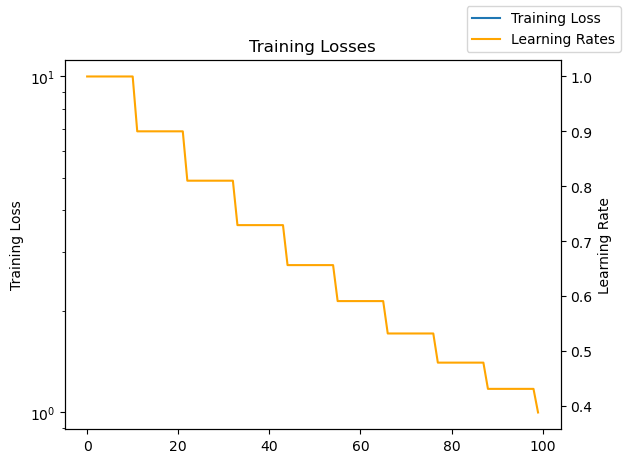

In [ ]:
fig, ax = plt.subplots()
ax.plot(losses, label='Training Loss')
ax.set_ylabel("Training Loss")
ax.set_yscale('log')
secax = ax.twinx()
secax.set_ylabel("Learning Rate")
secax.plot(lrs, label="Learning Rates", color='orange')
#secax.set_yscale('log')
ax.set_title("Training Losses")
fig.legend()
plt.show()

In [ ]:
# %%
with torch.no_grad():
    output_states = integrator(initial_state, control_inputs)
    val_loss = torch.nn.functional.l1_loss(output_states, target_states)

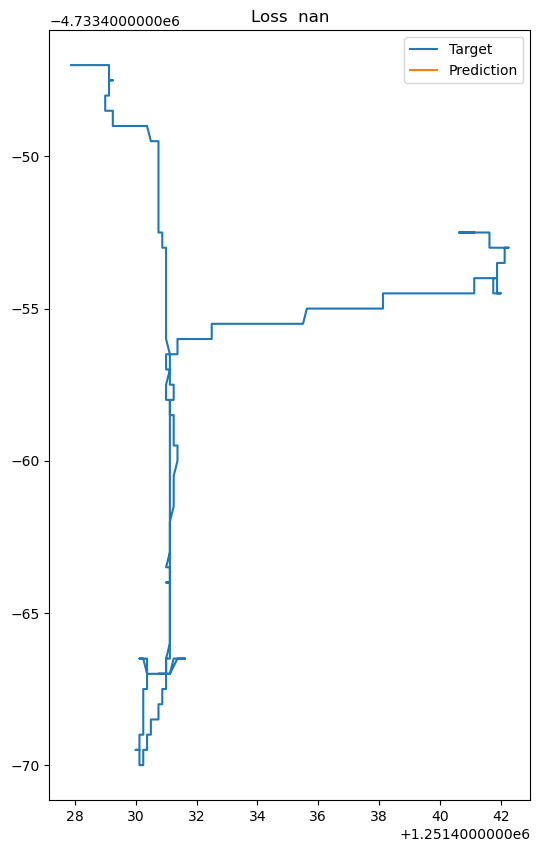

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
LEN=20000
ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
ax.set_aspect(1.0)
ax.legend()
ax.set_title("Loss {:4f}".format(val_loss.item()))
plt.show()

In [ ]:
print("{")
for key in dynamics.state_dict().keys():
    print(f"\t\"{key}\" : {dynamics.state_dict()[key]},")
print("}")

{
	"lf" : 0.27250000834465027,
	"lr" : 0.25850000977516174,
	"Iz" : nan,
	"mass" : nan,
	"Df" : nan,
	"Cf" : nan,
	"Bf" : nan,
	"Dr" : nan,
	"Cr" : nan,
	"Br" : nan,
	"Cm" : nan,
	"Cr0" : nan,
	"Cr2" : nan,
}
